# Landau-Lifshitz-Bloch simulations

In [44]:
from IPython.display import display

Here we calculate the vectorial magnetization dynamic in a magnetic heterostructure employing the mean-field quantum Landau-Lifshitz-Bloch (LLB) apporach. Please read the following review to get an overview of the LLB equation in ultrafast magnetism

U. Atxitia, D. Hinzke, and U. Nowak,  
*Fundamentals and Applications of the Landau-Lifshitz-Bloch Equation*,
[J. Phys. D. Appl. Phys. 50, (2017).](https://doi.org/10.1088/1361-6463/50/3/033003)

Here we need to solve the following differential equation:

\begin{align*}
\frac{d\mathbf{m}}{dt}=\gamma_e \left(\mathbf{m} \times
              \mathbf{H}_\mathrm{eff} + \frac{\alpha_{\perp}}{m^2}\mathbf{m}
              \times (\mathbf{m} \times \mathbf{H}_\mathrm{eff}) -
              \frac{\alpha_{\parallel}}{m^2}(\mathbf{m} \cdot
              \mathbf{H}_\mathrm{eff}) \cdot \mathbf{m}\right)
\end{align*}

The three terms describe

1. **precession** at Larmor frequency,
2. **transversal damping** (conserving the macrospin length), and
3. **longitudinal damping** (changing macrospin length due to incoherent
   atomistic spin excitations within the layer the macrospin is
   defined on).

$\alpha_{\parallel}$ and $\alpha_{\perp}$ are the longitudinal damping and transverse damping parameters, respectively.
$\gamma_e = -1.761\times10^{11}\,\mathrm{rad\,s^{-1}\,T^{-1}}$ is
the gyromagnetic ratio of an electron.

The effective magnetic field is the sum of all relevant magnetic
interactions:

\begin{align*}
    \mathbf{H}_\mathrm{eff} = \mathbf{H}_\mathrm{ext}
      + \mathbf{H}_\mathrm{A}
      + \mathbf{H}_\mathrm{ex}
      + \mathbf{H}_\mathrm{th}
\end{align*}

where

* $\mathbf{H}_\mathrm{ext}$ is the external magnetic field
* $\mathbf{H}_\mathrm{A}$ is the uniaxial anisotropy field
* $\mathbf{H}_\mathrm{ex}$ is the exchange field
* $\mathbf{H}_\mathrm{th}$ is the thermal field

The definitions of these subterms are described in their respective [API documentation](../magnetization.html#udkm1Dsim.simulations.magnetization.LLB).

**The material parameters of the current example arbitrarily chosen.**

## Setup

Do all necessary imports and settings.

In [45]:
import udkm1Dsim as ud
u = ud.u  # import the pint unit registry from udkm1Dsim
import scipy.constants as constants
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
u.setup_matplotlib()  # use matplotlib with pint units

In [46]:
Ni = ud.Atom('Ni', mag_amplitude=1, mag_gamma=90*u.deg, mag_phi=0*u.deg)
Si = ud.Atom('Si')

Solving the LLB requires several additional parameters of the according `Layer` objects:

* `eff_spin` - effective spin
* `curie_temp` - Curie temperature
* `lamda` - parameter used in the longitudinal & transversal damping terms $\alpha_\parallel$ & $\alpha_\perp$ (misspelled because of python `lambda`-functions)
* `mag_moment` - atomic magnetic moment
* `aniso_exponent` - exponent of the uniaxial anisotropy
* `anisotropy` - vector of the anisotropy $[K_x, K_y, K_z]$
* `exch_stiffness` - vector of the exchange stiffness $[A_{i\rightarrow (i-1)}, A_{i\rightarrow i}, A_{i\rightarrow (i+1)}]$
* `mag_saturation` - zero temperature saturation magnetization

The correct physical units and more details are documented in the [Layer API](../layers.html#udkm1Dsim.structures.layers.Layer).

In [47]:
prop_Ni = {}


# Two-temperture model
prop_Ni['heat_capacity'] = ['lambda T: 0.12*T', 442*u.J/(u.kg * u.K)] 
# 0.08*T (Zahn 2021, 10.1103/PhysRevResearch.3.023032)
# el: 10.1016/S0301-0104(99)00330-4, ph: 10.1016/0022-3697(81)90174-8
prop_Ni['therm_cond'] = ['lambda T: (81.4)*(T[0]/T[1])', 9.6] # 10.1016/S0301-0104(99)00330-4
prop_Ni['sub_system_coupling'] = ['lambda T:3.6e17*(T[1]-T[0])', 
         'lambda T:3.6e17*(T[0]-T[1])']  # 10.1103/PhysRevB.77.075133
prop_Ni['lin_therm_exp'] = ['lambda T: 0.0041e-6*T', 20.2e-6]

# Elastic parameters
prop_Ni['elastic_c11'] = 327e9*u.kg/(u.m*u.s**2)  # 10.1063/1.1702218: c11=253, c12=152, c44=124
prop_Ni['elastic_c12'] = 128e9*u.kg/(u.m*u.s**2)  # 10.1063/1.1702218: c11=253, c12=152, c44=124
prop_Ni['elastic_c13'] = 103e9*u.kg/(u.m*u.s**2)  # 10.1063/1.1702218: c11=253, c12=152, c44=124
prop_Ni['elastic_c22'] = 327e9*u.kg/(u.m*u.s**2)  # 10.1063/1.1702218: c11=253, c12=152, c44=124
prop_Ni['elastic_c23'] = 103e9*u.kg/(u.m*u.s**2)  # 10.1063/1.1702218: c11=253, c12=152, c44=124
prop_Ni['elastic_c33'] = 351e9*u.kg/(u.m*u.s**2)  # 10.1063/1.1702218: c11=253, c12=152, c44=124
prop_Ni['sound_vel'] = 6.3*u.nm/u.ps  # calculated -- np.sqrt(c33/density)

# Optical parameters
prop_Ni['opt_ref_index'] = 2.9174+3.3545j

prop_Ni['eff_spin'] = 0.5
prop_Ni['curie_temp'] = 630*u.K
prop_Ni['lamda'] = 0.08
prop_Ni['mag_moment'] = 0.393*u.bohr_magneton
prop_Ni['aniso_exponent'] = 3
prop_Ni['anisotropy'] = [-500, 0., 7.72e4]*u.J/u.m**3
prop_Ni['exch_stiffness'] = [15e-15, 15e-15, 15e-15]*u.J/u.m
prop_Ni['mag_saturation'] = 4e5*u.J/u.T/u.m**3
# build the layer
layer_Ni = ud.AmorphousLayer('Ni', 'Ni amorphous', thickness=1*u.nm,
                             density=7000*u.kg/u.m**3, atom=Ni, **prop_Ni)

Number of subsystems changed from 1 to 2.


In [48]:
# this is the non-magnetic substrate
prop_Si = {}
prop_Si['heat_capacity'] = [100*u.J/u.kg/u.K, 603*u.J/u.kg/u.K]
prop_Si['therm_cond'] = [0, 100*u.W/(u.m*u.K)]

prop_Si['sub_system_coupling'] = [0, 0]

prop_Si['lin_therm_exp'] = [0, 2.6e-6]
prop_Si['sound_vel'] = 8.433*u.nm/u.ps
prop_Si['opt_ref_index'] = 3.6941+0.0065435j

layer_Si = ud.AmorphousLayer('Si', "Si amorphous", thickness=1*u.nm, density=2336*u.kg/u.m**3,
                             atom=Si, **prop_Si)

Number of subsystems changed from 1 to 2.


In [49]:
S = ud.Structure('Ni 20')

S.add_sub_structure(layer_Ni, 20)
S.add_sub_structure(layer_Si, 200)

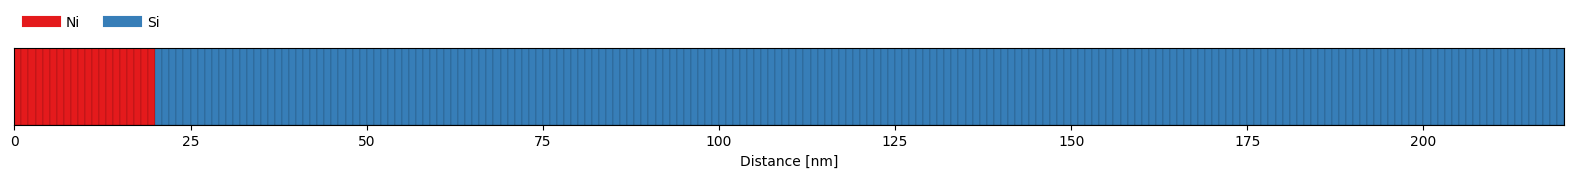

In [50]:
S.visualize()

## Initialize Heat and the Excitation

In [51]:
h = ud.Heat(S, True)

h.save_data = False
h.disp_messages = True

In [52]:
h.excitation = {'fluence': [1.2]*u.mJ/u.cm**2,
                'delay_pump':  [0]*u.ps,
                'pulse_width':  [0.15]*u.ps,
                'multilayer_absorption': True,
                'wavelength': 800*u.nm,
                'theta': 90*u.deg}
# temporal and spatial grid
delays = np.r_[-5000:-10:0.5, -10:10:0.05, 10:1000:0.2]*u.ps
_, _, distances = S.get_distances_of_layers()

## Calculate Heat Diffusion for 2-Temperature Model

In [53]:
# enable heat diffusion
h.heat_diffusion = True
# set the boundary conditions
h.boundary_conditions = {'top_type': 'isolator', 'bottom_type': 'isolator'}
# The resulting temperature profile is calculated in one line:

temp_map, delta_temp = h.get_temp_map(delays, 300)

Surface incidence fluence scaled by factor 1.0000 due to incidence angle theta=90.00 deg
Calculating _heat_diffusion_ for excitation 1:1 ...
Absorption profile is calculated by multilayer formalism.
Total reflectivity of 54.6 % and transmission of 22.8 %.


0it [00:00, ?it/s]

KeyboardInterrupt: 

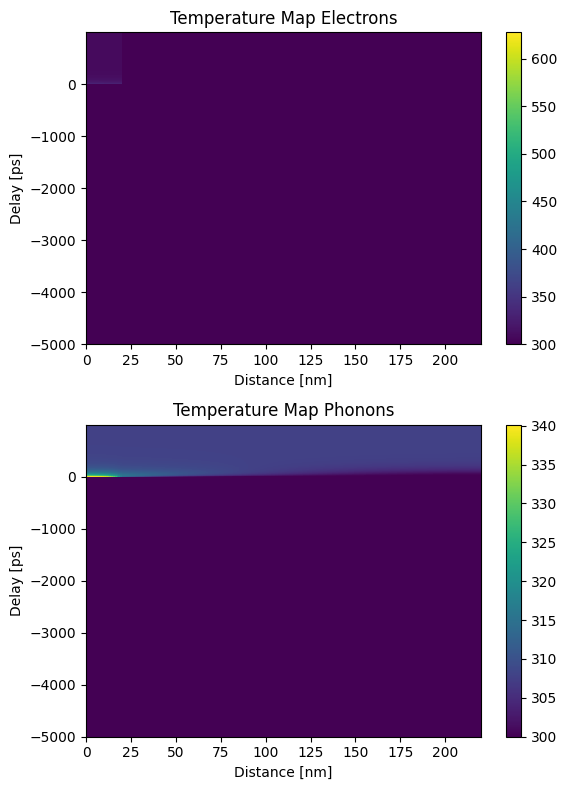

In [33]:
plt.figure(figsize=[6, 8])
plt.subplot(2, 1, 1)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, temp_map[:, :, 0],
               shading='auto')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Temperature Map Electrons')

plt.subplot(2, 1, 2)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, temp_map[:, :, 1],
               shading='auto')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Temperature Map Phonons')

plt.tight_layout()
plt.show()

## Strain simulations

Calculating linear thermal expansion ...
Calculating coherent dynamics with ODE solver ...


0it [00:00, ?it/s]

Elapsed time for _strain_map_: 3.202451 s


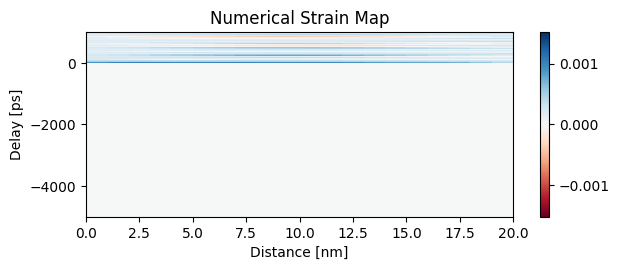

In [34]:
pnum = ud.PhononNum(S, True)
pnum.save_data = False
pnum.disp_messages = True


strain_map = pnum.get_strain_map(delays, temp_map, delta_temp)


plt.subplot(2, 1, 2)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude,
               strain_map, cmap='RdBu', vmin=-np.max(strain_map),
               vmax=np.max(strain_map), shading='auto')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Numerical Strain Map')
plt.xlim(0,20)
plt.tight_layout()
plt.show()

## Landau-Lifshitz-Bloch Simulations

The `LLB` class requires a `Structure` object and a boolean `force_recalc` in order to overwrite previous simulation results.

These results are saved in the `cache_dir` when `save_data` is enabled.
Printing simulation messages can be en-/disabled using `disp_messages` and progress bars can be enabled using the boolean switch `progress_bar`.

In [35]:
llb = ud.LLB(S, True)

llb.save_data = False
llb.disp_messages = True

print(llb)

Landau-Lifshitz-Bloch Magnetization Dynamics simulation properties:

Magnetization simulation properties:

This is the current structure for the simulations:

Structure properties:

Name   : Ni 20
Thickness : 220.0000 nanometer
Roughness : 0.0000 nanometer
----
20 times Ni amorphous: 20.0000 nanometer
200 times Si amorphous: 200.0000 nanometer
----
no substrate


Display properties:

================  =======
       parameter  value
================  =======
    force recalc  True
 cache directory  ./
display messages  True
       save data  False
    progress bar  True
================  =======


### Brillouin Function

Internally, the LLB calculates a mean-field magnetization map for the according electron temperatures
$T_e$ at for every layer and for every time step. This is done by solving the *Brillouin* function of each
layer and then mapping the result onto the according spatio-temporal grid, as given by the `temp_map`.

In [36]:
mean_field_mag_map = llb.get_mean_field_mag_map(temp_map[:, :, 0])

Calculating _mean_field_magnetization_map_ ...
Elapsed time for _mean_field_magnetization_map_: 1.548111 s


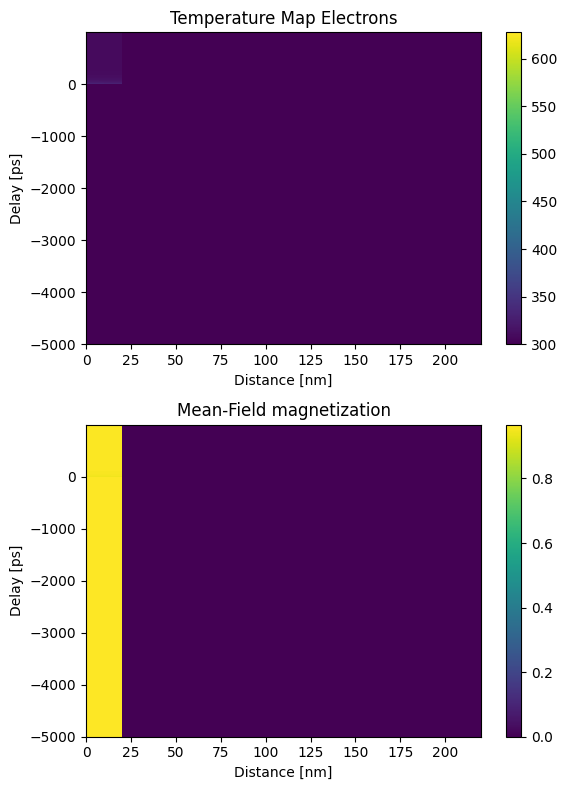

In [37]:
plt.figure(figsize=[6, 8])

plt.subplot(2, 1, 1)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, temp_map[:, :, 0],
               shading='auto')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Temperature Map Electrons')

plt.subplot(2, 1, 2)

plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, mean_field_mag_map, shading='auto')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Mean-Field magnetization')

plt.tight_layout()

plt.show()

## Structure

Refer to the [structure-example](structure.ipynb) for more details.  
We are providing a magnetization of the atoms which are used as initial magnetization in the LLB simulations, in case no specific initial condition is provided by the user.

In order to run the actual LLB simulation, an optional initial magnetization `init_mag` as well as an external magnetic field `H_ext` can be provided.
While `H_ext` is provided in cartesian coordinates $[H_x, H_y, H_z]$ in Tesla, the initial magnetization is given in polar coordinates $[A, \phi, \gamma]$ in units of [none, rad, rad], following the definitions shown in the [user guide](../user_guide.html#).

Running the simulation is done by calling the `get_magnetization_map` method which requires a `delay` vector as well as the `temp_map`.
The resulting `magnetization_map` is returned in **polar coordinates**.

In [38]:
init_mag = np.array([1.0, (0.*u.deg).to('rad').magnitude, (0*u.deg).to('rad').magnitude])

H_amp = 0.4
phi = np.deg2rad(80)
magnetization_map = llb.get_magnetization_map(delays, temp_map=temp_map,strain_map= np.zeros_like(temp_map[:,:,0]), init_mag=init_mag,
                                              H_ext=np.array([H_amp*np.cos(phi), 0, H_amp*np.sin(phi)]))

Calculating _magnetization_map_ ...
Calculating _mean_field_magnetization_map_ ...
Elapsed time for _mean_field_magnetization_map_: 1.484852 s


0it [00:00, ?it/s]

/home/friweber/udkm1Dsim_LLG-LLB/udkm1Dsim/simulations/magnetization.py:1035: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  H_me[:, 2] = -magnetoelastic_constants[2]/mag_saturations * strains * mag_map[:, 2]


Elapsed time for _LLB_: 159.406016 s
Elapsed time for _magnetization_map_: 159.406323 s


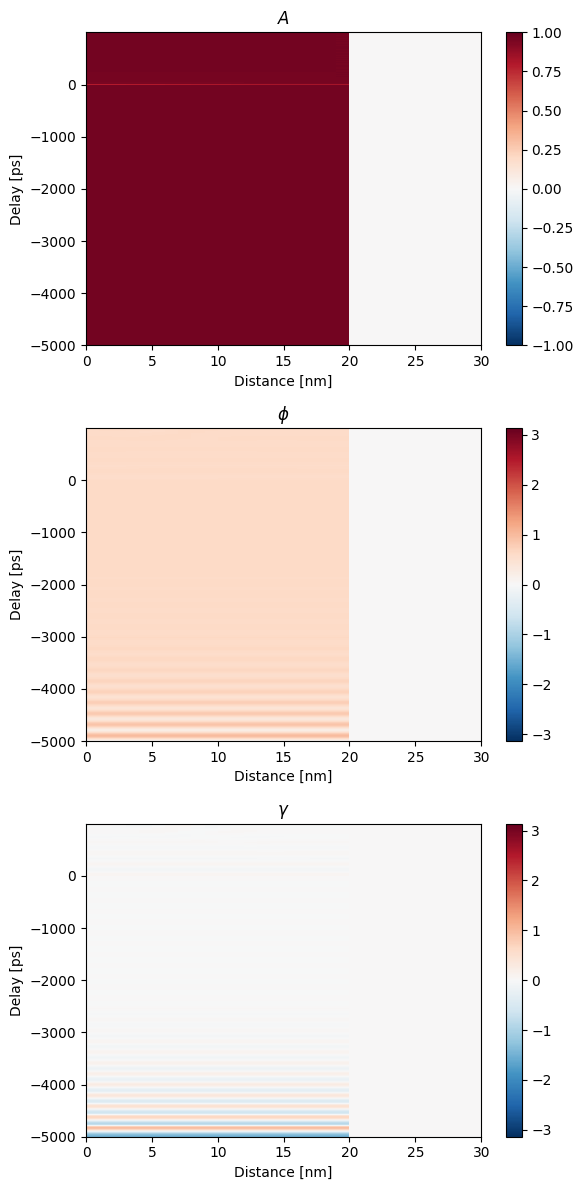

In [39]:
plt.figure(figsize=[6, 12])

plt.subplot(3, 1, 1)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, magnetization_map[:, :, 0],
               shading='auto', cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('$A$')

plt.xlim(0,30)

plt.subplot(3, 1, 2)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, magnetization_map[:, :, 1],
               shading='auto', cmap='RdBu_r', vmin=-3.14, vmax=3.14)
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('$\phi$')

plt.xlim(0,30)

plt.subplot(3, 1, 3)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, magnetization_map[:, :, 2],
               shading='auto', cmap='RdBu_r', vmin=-3.14, vmax=3.14)
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('$\gamma$')

plt.xlim(0,30)
plt.tight_layout()
plt.show()

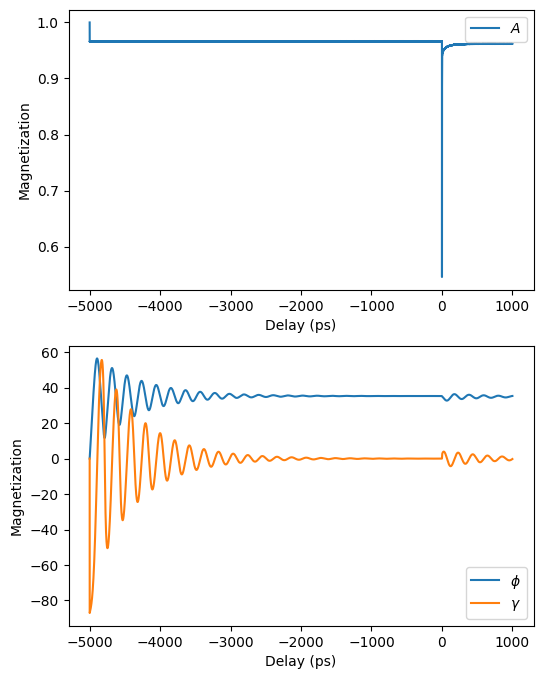

In [40]:
plt.figure(figsize=[6,8])
plt.subplot(2,1,1)
plt.plot(delays, np.mean(magnetization_map[:, 0:20, 0], axis=1), label=r'$A$')
plt.legend()
plt.xlabel('Delay (ps)')
plt.ylabel('Magnetization')
plt.subplot(2,1,2)
plt.plot(delays, (np.mean(magnetization_map[:, 0:20, 1], axis=1)*u.rad).to('deg'), label=r'$\phi$')
plt.plot(delays, (np.mean(magnetization_map[:, 0:20, 2], axis=1)*u.rad).to('deg'), label=r'$\gamma$')
plt.legend()
plt.xlabel('Delay (ps)')
plt.ylabel('Magnetization')
plt.show()

The `helper` modules provides functions to convert the result also into cartesian coordinates:

In [41]:
magnetization_map_xyz = ud.helpers.convert_polar_to_cartesian(magnetization_map)

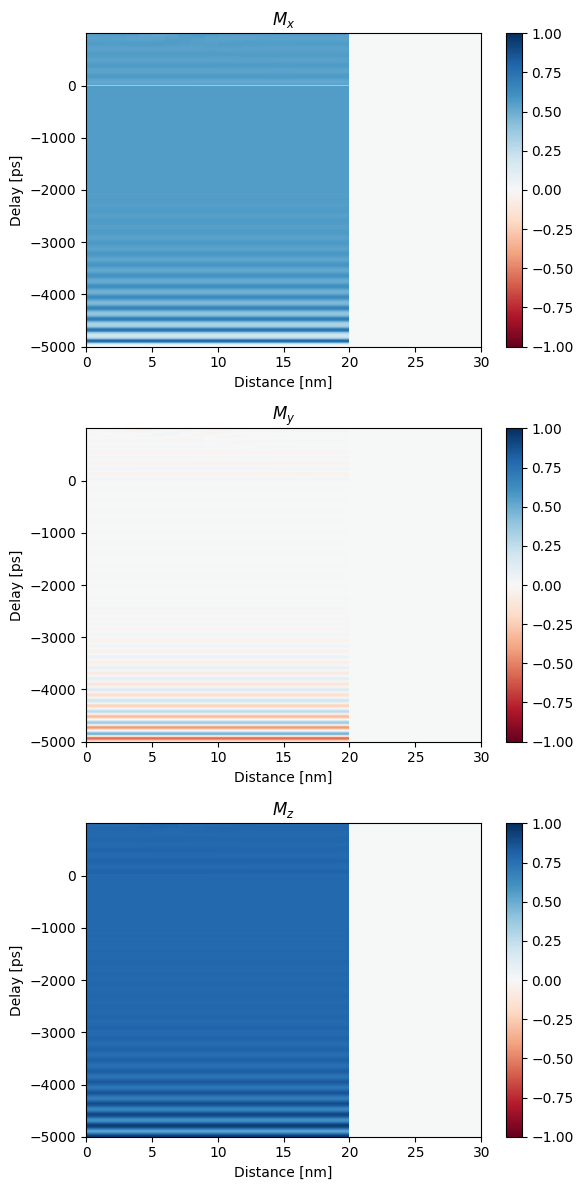

In [42]:
plt.figure(figsize=[6, 12])
plt.subplot(3, 1, 1)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, magnetization_map_xyz[:, :, 0],
               shading='auto', cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('$M_x$')

plt.xlim(0,30)

plt.subplot(3, 1, 2)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, magnetization_map_xyz[:, :, 1],
               shading='auto', cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('$M_y$')

plt.xlim(0,30)

plt.subplot(3, 1, 3)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, magnetization_map_xyz[:, :, 2],
               shading='auto', cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('$M_z$')

plt.xlim(0,30)
plt.tight_layout()
plt.show()

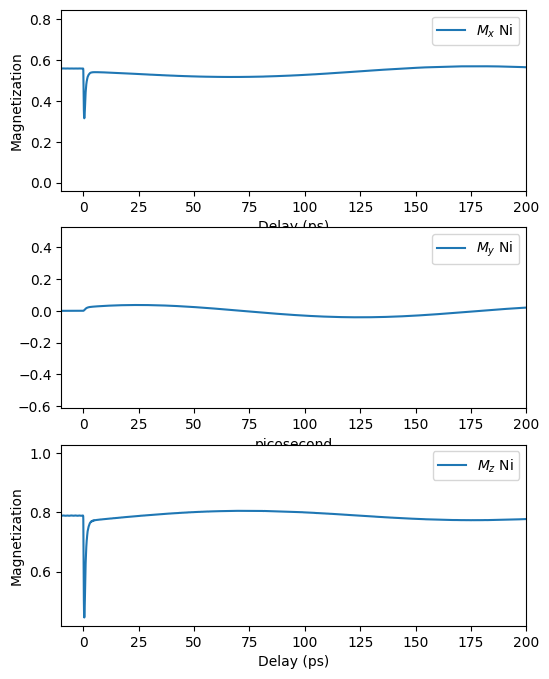

In [43]:
plt.figure(figsize=[6,8])
plt.subplot(3,1,1)
plt.plot(delays, np.mean(magnetization_map_xyz[:, 0:20, 0], axis=1), label=r'$M_x$ Ni')
plt.legend()
plt.xlim(-10,200)
plt.xlabel('Delay (ps)')
plt.ylabel('Magnetization')
plt.subplot(3,1,2)
plt.plot(delays, np.mean(magnetization_map_xyz[:, 0:20, 1], axis=1), label=r'$M_y$ Ni')
plt.legend()
plt.xlim(-10,200)
plt.subplot(3,1,3)
plt.plot(delays, np.mean(magnetization_map_xyz[:, 0:20, 2], axis=1), label=r'$M_z$ Ni')
plt.legend()
plt.xlabel('Delay (ps)')
plt.ylabel('Magnetization')
plt.xlim(-10,200)
plt.show()

In both subplots it is obvious that the magnetization already starts to change before the actual laser excitation raises the electronic temperatures.
This is because of the misalignment of the initial magnetization and the external magnetic field.
To avoid this, the steady-state solution of the layer magnetization must be found first and used as `init_mag` for the actual transient simulations.